# Nudge Elastic Band exercise

In this exercise we will use the Climbing Image Nudged Elastic Band method to identify transition
states for Cu adatom diffusion on Cu(110).

We will be using EMT in this exercise, but note that when using DFT methods, NEB easily gets too expensive to run locally, so later in the course we will be submitting these types of calculations to the cluster.

## Calculate the lattice of bulk Cu with EMT

Perform a series of EMT calculations around the experimental Cu lattice constant and save the calculations to a trajectory. See below for inspiration on how to do this.

You can use https://en.wikipedia.org/wiki/Periodic_table_%28crystal_structure%29 and https://en.wikipedia.org/wiki/Lattice_constant to find a good starting value for the lattice parameter of Cu in an FCC lattice. Note that EMT will not find the exact lattice parameter which is known from experiments though!

View the files in the ASE gui, and use the Tools/Bulk Modulus functionality to fit an equation of state.

Questions:
* What is the lattice constant and bulk modulus with EMT?
* What is the energy per atom of bulk Cu in EMT?

In [1]:
%%writefile Cu_fcc.py
import numpy as np

from ase import Atoms
from ase.io.trajectory import Trajectory 
from ase.calculators.emt import EMT
from ase.build import bulk

a = 3.7  #  trial lattice constant
atoms = bulk('Cu', crystalstructure='fcc', a=a, cubic=True)
calc = EMT()
atoms.set_calculator(calc)

traj = Trajectory('bulk-relax.traj', mode='w', atoms=atoms)

scales = np.linspace(0.92, 1.08, 15)  # modify the lattice parameter by +/- 8% in 15 steps

for i, scale in enumerate(scales):
    atoms.set_cell(scale * np.array((a, a, a)), scale_atoms=True)
    e = atoms.get_potential_energy()
    traj.write()
    print('New a: {:.3f}\tEnergy: {:.3f}'.format(scale*a, e))

Writing Cu_fcc.py


In [3]:
!qsub.py -p 8 -t 1 Cu_fcc.py

7289262.hnode2


In [7]:
a0 = 46.214**(1/3) #lattice constant
print(a)

3.5885955975046637


In [10]:
E = -0.028/4 #energy per atom
print(E)

-0.007


In [ ]:
from ase.visualize import view
from ase.io import read
bulk = read('bulk-relax.traj@:')
view(bulk)

## Set up a Cu(110) surface using the ase.build.surface module

In the following, we will set up a Cu(110) surface with a Cu adatom, see the below script for inspiration.

Question:
* What is the reaction energy of $$\text{Cu(bulk)} + \text{Cu(110)} \rightarrow \text{Cu@Cu(110)}$$ where Cu@Cu(110) is the (110) surface with an adatom.

In [15]:
import numpy as np

from ase import Atoms
from ase.calculators.emt import EMT
from ase.optimize import BFGS
from ase.build.surface import fcc110, add_adsorbate
from ase.constraints import FixAtoms

a0 = 3.589 # use calculated lattice constant

size = (4, 4, 7)
slab = fcc110('Cu', a=a0, size=size, vacuum=7.)
cell = slab.get_cell()

# optimize the top 4 layers
mask = [a.tag > 4 for a in slab]
slab.set_constraint(FixAtoms(mask=mask))

# add adsorbate where you want it
pos = np.array([1, 0])  # Adjust to move around adsorbed Cu atom - offset in (x, y) direction by 1 lattice vector
posname = 'a' + ''.join(str(p) for p in pos)  # a00, a10, a01

add_adsorbate(slab, 'Cu',
              0.7*a0,  # Height above slab
              position=pos*a0,  # Position above the Cu slab.
              offset=(0.5, 0.5))

if 0: # for viewing only. Set to 1 to view, and 0 to ignore
    from ase.visualize import view
    view(slab)
    assert False # Hack to break the execution by raising an error intentionally.

# Relax the cell using EMT
calc = EMT()
slab.set_calculator(calc)

dyn = BFGS(slab, trajectory='Cu110_{}.traj'.format(posname))
dyn.run(fmax=0.01)
e_110 = slab.get_potential_energy()

      Step     Time          Energy         fmax
BFGS:    0 11:04:33       23.801325        1.4400
BFGS:    1 11:04:33       23.760709        1.4688
BFGS:    2 11:04:33       23.681782        1.5253
BFGS:    3 11:04:33       23.602891        1.5818
BFGS:    4 11:04:33       23.524061        1.6350
BFGS:    5 11:04:33       23.445397        1.6813
BFGS:    6 11:04:33       23.367179        1.7214
BFGS:    7 11:04:33       23.289632        1.7571
BFGS:    8 11:04:34       23.212961        1.7882
BFGS:    9 11:04:34       23.137428        1.8134
BFGS:   10 11:04:34       23.063368        1.8310
BFGS:   11 11:04:34       22.991194        1.8396
BFGS:   12 11:04:34       22.921396        1.8377
BFGS:   13 11:04:34       22.854534        1.8238
BFGS:   14 11:04:34       22.791244        1.7963
BFGS:   15 11:04:34       22.732236        1.7536
BFGS:   16 11:04:35       22.678297        1.6935
BFGS:   17 11:04:35       22.630288        1.6138
BFGS:   18 11:04:35       22.589112        1.5127
B

## CI-NEB

Use the CI-NEB method to calculate activation energies for Cu adatom diffusion on Cu(110). See the script below for inspiration on how to run the CI-NEB calculation in ASE. The initial and final states are constructed in the above script.

You can use the ase-gui to plot minimum energy pathway (MEP) using the command `ase gui CINEB.traj@-10:` and then chose the menu Tools/NEB. Remember that you can run terminal commands in the notebook by starting the line with `!`. Note that the `-10` at the end of the command means "look at the last 10 images of `CINEB.traj`. The reason we chose 10, is because we chose to have 10 images in total.

Questions:
* Show a MEP for diffusion in the [0 0 1] direction (hopping over a "long bridge")
* Show a MEP for diffusion in the [1 -1 0] direction (hopping over a "short bridge")
* Can you imagine other diffusion steps?

In [19]:
import numpy as np

from ase.io import read, write
from ase.calculators.emt import EMT
from ase.neb import NEB
from ase.optimize import LBFGS as Optimizer

initial = read('Cu110_a00.traj@-1') # read structure of initial state
final = read('Cu110_a01.traj@-1') # read structure of final state

# initialize NEB
Nimages = 8 # number of images

configs = [initial]
for i in range(Nimages):
    config = initial.copy()
    config.set_calculator(EMT())
    configs.append(config)
configs.append(final)

band = NEB(configs)
band.interpolate()

# optimize NEB
relax = Optimizer(band, trajectory='a01-NEB.traj')
relax.run(steps=50, fmax=0.1)

if 1: # CINEB
    ciband = NEB(configs, climb=True)
    cirelax = Optimizer(ciband, trajectory='a01-CINEB.traj')
    cirelax.run(steps=200, fmax=0.02) 

       Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
LBFGS:    0 11:12:01       22.557468*       2.3812
LBFGS:    1 11:12:02       22.372863*       1.5603
LBFGS:    2 11:12:03       22.245220*       0.7550
LBFGS:    3 11:12:04       22.192077*       0.2741
LBFGS:    4 11:12:05       22.182807*       0.2520
LBFGS:    5 11:12:05       22.175051*       0.3478
LBFGS:    6 11:12:06       22.162787*       0.4009
LBFGS:    7 11:12:07       22.153367*       0.3334
LBFGS:    8 11:12:08       22.147752*       0.2001
LBFGS:    9 11:12:08       22.143877*       0.2243
LBFGS:   10 11:12:09       22.138810*       0.2617
LBFGS:   11 11:12:10       22.132439*       0.2058
LBFGS:   12 11:12:11       22.128484*       0.1062
LBFGS:   13 11:12:12       22.126274*       0.1090
LBFGS:   14 11:12:12       22.123829*       0.1116
LBFGS:   15 11:12:13       22.121267*       0.1061
LBFGS:   16 11:12:14       22.119712*       0.0711
       Step     Time          Ener

In [20]:
!ase gui a01-CINEB.traj@-10:

## Vibrational Analysis

Calculate vibrational frequencies for the initial state and transition states. See below for inspiration on how to do this.

Questions:
* How many imaginary modes are there at the initial states and transition states?
* Describe the imaginary mode(s) of the transition state?

In [4]:
import numpy as np

from ase import Atoms
from ase.calculators.emt import EMT
from ase.vibrations import Vibrations

from ase.io import read

#slab = read('Cu110_a00.traj@-1') # read initial 
#slab = read('a10-CINEB.traj@-6') # reaad the trnsition state (the image at the saddle point)
slab = read('a01-CINEB.traj@-6') # reaad the trnsition state (the image at the saddle point)
slab.set_calculator(EMT())

vibindices = [atom.tag < 1 for atom in slab] # vibrate only atoms with tag < 0
                                             # (here it means: vibrate only adatom)
vibindices = np.array(vibindices).nonzero()[0] # extract indices of atoms to be vibrated

vib = Vibrations(slab, 
                 name='transition_a01-vib', # Can be a good idea to adjust this name, for different systems
                 indices=vibindices, nfree=4, delta=0.01) # set up vibrational analysis calculation
                 # slab - Atoms object for which we are running vib
                 # indices - indices of atoms to be vibrated
                 # nfree - method; 4 displacements (see Wikipedia: five-point stencil)
                 # delta - displacement
                 # See documentation for Vibrations: https://wiki.fysik.dtu.dk/ase/ase/vibrations/vibrations.html
vib.run() # run vibrational analysis calculation
vib.summary() # show vibrational modes' wavenumbers

for i in range(3):
    vib.write_mode(i) # write modes

#    You can visualize normal modes with
#         ase gui vib.x.traj
#    in the console, where x is the mode number (0, 1 or 2)

---------------------
  #    meV     cm^-1
---------------------
  0    6.0i     48.1i
  1   19.3     155.7 
  2   22.5     181.7 
---------------------
Zero-point energy: 0.021 eV


In [32]:
!ase gui transition_a01-vib.1.traj

## Rate Analysis
Use transition state theory to estimate the rate of atom hopping in the [1 -1 0] and [0 0 1] directions as function of temperature.

Plot this estimate as function of temperature.

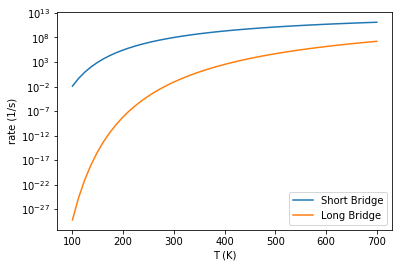

In [2]:
%matplotlib inline
import numpy as np
from ase.vibrations import Vibrations
from ase.io import read
from ase.calculators.emt import EMT
import matplotlib.pyplot as plt

# Calculated barriers
barriers = {'01': 0.290 , '10': 0.832}

directions = ['01', '10']

def rate(T, ens0, ens1, Eb):
    '''
    T: Temperature
    ens0: energies of initial state in a numpy array
    ens1: energies of transition state in a numpy array
    Eb: Transition state barrier
    '''
      
    k = 8.617e-5   # Boltzmann constant in [eV/K]
    h = 4.135e-15  # Planck constant in [eV*s]
    
    # Calculate partition functions
    z0 = np.sum(np.exp(-ens0/(k*T))) #initial state
    z1 = np.sum(np.exp(-ens1/(k*T))) #transition state

    # Calculate rate
    r = (z1/z0)*(k*T/h)*np.exp(-Eb/(k*T))
    return r


energies = {}
for direction in directions:
    energies[direction] = []
    for ii, index in enumerate([-10, -6]):  # Loop through initial and transition state
        # Use loop index as:  ii = 0: Initial, ii = 1: Final
        
        slab = read('a{}-CINEB.traj'.format(direction), index=index)

        slab.set_calculator(EMT())
        
        vib = Vibrations(slab, 
                         name='{}_{}-vib'.format(ii, direction),
                         indices=[112],  # Atom index to vibrate
                         nfree=4, delta=0.01)
        vib.run()
        en = np.real(vib.get_energies())  # Get real part of vibrational energies
        energies[direction].append(en)
        
plt.figure()
labels = {'01': 'Short Bridge',
          '10': 'Long Bridge'}

x = np.linspace(100, 700, 50)  # Temperature range in K
for direction in directions:
    ens0, ens1 = energies[direction]
    Eb = barriers[direction]
    y = [rate(T, ens0, ens1, Eb) for T in x]
    plt.semilogy(x, y, label=labels[direction])
plt.legend(loc='best')
plt.xlabel('T (K)')
plt.ylabel('rate (1/s)')
plt.savefig('rates.png')
plt.show()